In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [23]:
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
numAssets = len(assets)
PERIODS = 252
dur = 20
riskFreeRate = 0.01

In [4]:
norm_data = pd.read_csv('norm_portfolio_data.csv')
norm_data['dateTime'] = pd.to_datetime(norm_data['dateTime'])
norm_data.set_index('dateTime', inplace=True)
norm_data.head()

,em15,ibtm,iusa,smea,phau,one,two,three,minvar,maxSharpe
dateTime,,,,,,,,,,
2010-05-26,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-05-27,1.001850,0.990071,0.999717,1.0,0.994098,0.996745,0.998887,1.000941,0.997261,1.000986
2010-05-28,0.999437,0.987447,0.997174,1.0,0.981380,0.993694,0.995866,0.998374,0.994327,0.998520
2010-05-31,0.997346,0.991277,0.999152,1.0,0.996540,0.996337,0.997731,0.998043,0.996124,0.998078
2010-06-01,0.996783,0.992908,0.997174,1.0,1.004681,0.997132,0.997946,0.997015,0.997181,0.996942


## PCT returns

In [33]:
pct_ret = norm_data.pct_change()
pct_ret.dropna(inplace=True)
pct_ret.head()

,em15,ibtm,iusa,smea,phau,one,two,three,minvar,maxSharpe
dateTime,,,,,,,,,,
2010-05-27,0.001850,-0.009929,-0.000283,0.000000,-0.005902,-0.003255,-0.001113,0.000941,-0.002739,0.000986
2010-05-28,-0.002408,-0.002650,-0.002544,0.000000,-0.012794,-0.003060,-0.003024,-0.002564,-0.002942,-0.002463
2010-05-31,-0.002092,0.003878,0.001984,0.000000,0.015448,0.002659,0.001873,-0.000332,0.001808,-0.000443
2010-06-01,-0.000564,0.001646,-0.001980,0.000000,0.008168,0.000798,0.000215,-0.001030,0.001061,-0.001138
2010-06-02,-0.001291,0.007786,-0.000850,0.024409,-0.000608,0.006732,0.004964,-0.001112,0.007309,-0.001112


In [34]:
u = pct_ret.maxSharpe.mean()
sigma = pct_ret.maxSharpe.std()

In [35]:
# annualized returns
# MODO 1
mu = (norm_data.maxSharpe.iloc[-1]/norm_data.maxSharpe.iloc[0]) ** (252/norm_data.shape[0]) - 1
vol = sigma * math.sqrt(252)
print(mu, vol)

# MODO 2
D = len(pct_ret.maxSharpe)
mu = pct_ret.maxSharpe.add(1).prod() ** (252 / D) - 1
vol = sigma * math.sqrt(252)
print(mu, vol)

0.09594583073801699 0.08190041284545442
0.09599043764540749 0.08190041284545442


In [88]:
### MONTECARLO

T = PERIODS
NUM_YEARS = 10
NUM_MC_RUNS = 1000
mc_runs = pd.DataFrame()

for i in range(NUM_MC_RUNS):
    # create list of daily returns using random normal distribution
    daily_returns=np.random.normal((mu/T),vol/math.sqrt(T), T * NUM_YEARS )

    random_walk = [1.0]
    for x in daily_returns:
        random_walk.append(random_walk[-1] * (1+x))
    
    mc_runs[i] = random_walk

In [89]:
mc_runs_returns = mc_runs.pct_change()
mc_runs_returns.dropna(inplace=True)

D = len(mc_runs_returns)
ann_mc_returns = mc_runs_returns.add(1).prod() ** (PERIODS / D) - 1
vol_mc_returns = mc_runs_returns.std() * math.sqrt(PERIODS)

sharpe_mc_runs = (ann_mc_returns - riskFreeRate) / vol_mc_returns

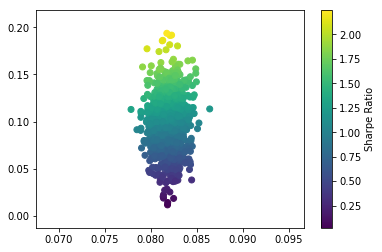

In [90]:
plt.scatter(vol_mc_returns, ann_mc_returns, c = sharpe_mc_runs,marker = 'o')
plt.colorbar(label = 'Sharpe Ratio')

In [95]:
# mc_runs.plot(legend=False, linewidth=1)

In [111]:
mc_stats = pd.DataFrame()
for i in [0,500,1000,1500,2000,mc_runs.shape[0]-1]:
    mc_stats[i] = mc_runs.iloc[i,:].describe([.1,.25,.5,.75,.9])

In [112]:
mc_stats

,0,500,1000,1500,2000,2520
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.0,1.207453,1.469599,1.780003,2.141126,2.620409
std,0.0,0.138825,0.240333,0.363283,0.505037,0.700147
min,1.0,0.879109,0.918237,0.908981,1.043331,1.125717
10%,1.0,1.039343,1.177965,1.342569,1.566352,1.844540
25%,1.0,1.109276,1.306353,1.533508,1.784824,2.132738
50%,1.0,1.198930,1.445414,1.746235,2.070765,2.518052
75%,1.0,1.287109,1.616889,1.979621,2.437080,3.006825
90%,1.0,1.385982,1.790698,2.265391,2.790258,3.526197
max,1.0,1.864355,2.508952,3.381399,4.264210,5.866881


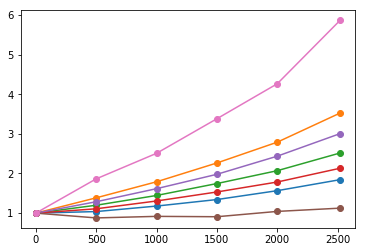

In [113]:
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['10%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['90%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['50%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['25%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['75%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['min'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['max'], marker='o')
plt.show()

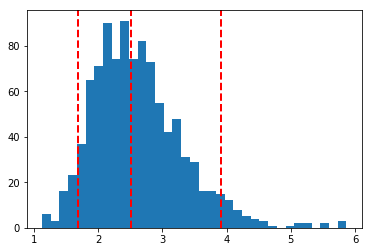

In [114]:
# Statistiche solo sul risultato finale

mc_end_results = mc_runs.iloc[2520]

plt.hist(mc_end_results, bins=35)
plt.axvline(mc_end_results.quantile(0.05), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.95), color='r', linestyle='dashed', linewidth=2)
plt.show()


## LOG returns

In [28]:
log_ret = np.log(norm_data/norm_data.shift(1))
log_ret.dropna(inplace=True)
log_ret.head()

,em15,ibtm,iusa,smea,phau,one,two,three,minvar,maxSharpe
dateTime,,,,,,,,,,
2010-05-27,0.001848,-0.009979,-0.000283,0.000000,-0.005919,-0.003261,-0.001114,0.000940,-0.002743,0.000985
2010-05-28,-0.002411,-0.002654,-0.002547,0.000000,-0.012877,-0.003065,-0.003029,-0.002567,-0.002946,-0.002466
2010-05-31,-0.002094,0.003871,0.001982,0.000000,0.015330,0.002656,0.001871,-0.000332,0.001806,-0.000443
2010-06-01,-0.000565,0.001644,-0.001982,0.000000,0.008135,0.000798,0.000215,-0.001030,0.001060,-0.001139
2010-06-02,-0.001292,0.007756,-0.000850,0.024116,-0.000608,0.006710,0.004951,-0.001113,0.007283,-0.001113


In [29]:
mu = log_ret.maxSharpe.mean() * PERIODS
vol = log_ret.maxSharpe.std() * math.sqrt(PERIODS)
print(mu)
print(vol)

0.09165846371167488
0.081945800231785


In [30]:
### MONTECARLO

T = PERIODS
NUM_YEARS = 10
NUM_MC_RUNS = 50
mc_runs = pd.DataFrame()

for i in range(NUM_MC_RUNS):
    # create list of daily returns using random normal distribution
    daily_returns=np.random.normal((mu/T),vol/math.sqrt(T), T * NUM_YEARS )

    random_walk = [1.0]
    for x in daily_returns:
        random_walk.append(random_walk[-1] + x)
    
    mc_runs[i] = random_walk

In [31]:
mc_runs_returns = np.log(mc_runs/mc_runs.shift(1))
mc_runs_returns.dropna(inplace=True)

ann_mc_returns = mc_runs_returns.mean() * PERIODS
vol_mc_returns = mc_runs_returns.std() * math.sqrt(PERIODS)

sharpe_mc_runs = (ann_mc_returns - riskFreeRate) / vol_mc_returns

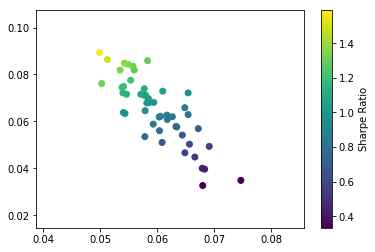

In [32]:
plt.scatter(vol_mc_returns, ann_mc_returns, c = sharpe_mc_runs,marker = 'o')
plt.colorbar(label = 'Sharpe Ratio')